In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.keras.layers import Add, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, MaxPool2D, ReLU, Concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Res-Net50 (backbone)

In [4]:
def res_block_simple(inp, stage, substage):    
    filters=inp.shape.as_list()[-1]//4
    conv=Conv2D(filters, 1, activation='relu', use_bias=False, name='res{0}{1}_branch2a'.format(stage, substage))(inp)   
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, name='res{0}{1}_branch2b'.format(stage, substage))(conv)
    conv=Conv2D(filters*4, 1, use_bias=False, name='res{0}{1}_branch2c'.format(stage, substage))(conv)    
    add=Add(name='res{0}{1}_'.format(stage, substage))([inp, conv])
    return ReLU(name='res{0}{1}'.format(stage, substage))(add)

def res_block_ext(inp, stage):    
    filters=inp.shape.as_list()[-1]//2
    strds=(2,2)
    if filters==32:
        filters=filters*2
        strds=(1,1)        
    conv=Conv2D(filters, 1, strides=strds, activation='relu', use_bias=False, name='res{0}a_branch2a'.format(stage))(inp)    
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, name='res{0}a_branch2b'.format(stage))(conv)     
    conv=Conv2D(filters*4, 1, use_bias=False, name='res{0}a_branch2c'.format(stage))(conv)    
    inp1=Conv2D(filters*4, 1, strides=strds, use_bias=False, name='res{0}a_branch1'.format(stage))(inp)    
    
    add=Add(name='res{0}a_'.format(stage))([conv,inp1])
    return ReLU(name='res{0}a'.format(stage))(add)

def get_res50(inp_shape=(500,500,3)):
    inp=Input(shape=inp_shape)
    conv=Conv2D(64, 7, padding='same', activation='relu', name='conv1')(inp)    
    out=MaxPool2D(strides=2, padding='same', name='pool1')(conv)    
    outputs=[conv]
    
    for num, blocks in enumerate([2,3,5,2]):
        stage=num+2
        out=res_block_ext(out, stage)
        for substage in 'bcdef'[:blocks]:
            out=res_block_simple(out, stage, substage)
        outputs.append(out)
    return Model(inputs=inp,outputs=outputs)

# Outlines and orientations branches

In [5]:
# crop like-caffe layer 
# class Crop(layers.Layer):
#     """centerred cropping of target layer by dimensions of template layer 
#     EXAMPLE:
#     cropped_lr=Crop(name='cropped_layer')(target, templ)
#     """
#     def __init__(self, **kwargs):
#         super(Crop, self).__init__(**kwargs) 
    
#     def compute_output_shape(self, input_shape):
#         sh=(input_shape[1][0],input_shape[1][1],input_shape[1][2],input_shape[0][3])
#         return sh
    
#     def call(self, x, trainable=False):
#         x_shape = tf.shape(x[0])
#         templ_sh= tf.shape(x[1])
        
#         offsets = [0, (x_shape[1] - templ_sh[1]) // 2, (x_shape[2] - templ_sh[2]) // 2, 0]
#         size = [-1, templ_sh[1], templ_sh[2], x_shape[3]]        
        
#         x_crop = tf.slice(x[0], offsets, size)
#         x_crop.set_shape(self.compute_output_shape([x[0].shape, x[1].shape]))
#         return x_crop

    
class Crop(layers.Layer):
    """cropping of target layer by dimensions of template layer according with stride of prev decov layer
    EXAMPLE:
    cropped_lr=Crop(name='cropped_layer')(target, templ)
    """
    def __init__(self, pad, **kwargs):
        super(Crop, self).__init__(**kwargs)
        self.pad=pad
    
    def compute_output_shape(self, input_shape):
        sh=(input_shape[1][0],input_shape[1][1],input_shape[1][2],input_shape[0][3])
        return sh
        
    def call(self, x, trainable=False):
        x_shape = tf.shape(x[0])
        templ_sh= tf.shape(x[1])  
        offsets = [0, self.pad-1, self.pad-1, 0]
        size = [-1, templ_sh[1], templ_sh[2], x_shape[3]]        
        
        x_crop = tf.slice(x[0], offsets, size)
        x_crop.set_shape(self.compute_output_shape([x[0].shape, x[1].shape]))
        return x_crop    
    
     
def DSN_deconv(lr, inp_lr):
    lr_name=lr.name.split('/')[0]
    lr_num=[int(s) for s in lr_name if s.isdigit()][0]    
    con=Conv2D(1,1, name='score-dsn{0}'.format(lr_num))(lr)
    st=1
    if lr_num>1:
        st=2**(lr_num-1)
        ks=st*2
        con=Conv2DTranspose(1,ks,(st,st), name='upsample_{0}'.format(st))(con)
    con=Crop(pad=st,name='crop{0}'.format(lr_num))([con, inp_lr])
    return con     

def get_outlines_net(res_inp, res_outp):
    DSN=[DSN_deconv(lr, res_inp) for lr in res_outp] 
    
    con1=Concatenate(name="concat1")(DSN[:-1])
    con1=Conv2D(1,1, name='new-score-weighting1')(con1)
    con1=Activation('sigmoid', name='sigmoid-fuse_scale_2.0')(con1)
    
    con2=Concatenate(name="concat3")(DSN[1:])
    con2=Conv2D(1,1, name='new-score-weighting3')(con2)
    con2=Activation('sigmoid', name='sigmoid-fuse_scale_0.5')(con2)
    return [con2, con1]
    #return {'sigmoid-fuse_scale_2.0':con1, 'sigmoid-fuse_scale_0.5':con2}
    
def orient_deconv(lr, inp_lr, orient):
    lr_name=lr.name.split('/')[0]
    lr_num=[int(s) for s in lr_name if s.isdigit()][0]    
    con=Conv2D(32,3, padding='same', name='{0}_or8_{1}'.format(lr_name, orient))(lr)
    con=Conv2D(4,3, padding='same', name='{0}_4_or8_{1}'.format(lr_name, orient))(con)
    
    st=1
    if lr_num>1:
        st=2**(lr_num-1)
        ks=st*2
#         con=Conv2DTranspose(4,ks,(st,st), name='{0}_4_or8_{1}-up'.format(lr_name, orient))(con)
        con=Conv2DTranspose(4,ks,(st,st), name='upsample_{0}_or8_{1}'.format(st, orient))(con)
                
    con=Crop(pad=st, name='{0}_4_or8_{1}_cropped'.format(lr_name, orient))([con, inp_lr])
    return con

def get_orientations_net(res_inp, res_outp):
    outputs=[]
    #outputs={}
    
    for i in range(1,9): 
        orients=[orient_deconv(lr, res_inp, i) for lr in res_outp]
        con=Concatenate(name='concat-upscore_or8_{0}'.format(i))(orients)
        #         con=Conv2D(1,3, padding='same', name='upscore-fuse_or8_{0}'.format(i))(con)
        
        con=Conv2D(1,3, padding='same', name='score-or8_{0}'.format(i))(con)
        
        con=Activation('sigmoid', name='sigmoid-fuse_or8_{0}'.format(i))(con)
        outputs.append(con)
        #outputs['sigmoid-fuse_or8_{0}'.format(i)]=con
    return outputs

# make and explore net

In [6]:
res50=get_res50(inp_shape=(None,None,3))
res_inp=res50.inputs
res_out=res50.output
orientations=get_orientations_net(res_inp[0], res_out)
outlines=get_outlines_net(res_inp[0], res_out)

orient_model=Model(res_inp, orientations+outlines)
# orient_model=Model(res_inp, {**outlines,**orientations})

In [ ]:
dot_img_file = 'res50_model.png'
tf.keras.utils.plot_model(orient_model, to_file=dot_img_file, show_shapes=True)

In [ ]:
orient_model.summary()

# assigning weights from caffe model

In [ ]:
#with cv2
import cv2
base=r'd:\Downloads\COB\models'
PRETRAINED = '{0}/COB_PASCALContext_trainval.caffemodel'.format(base)
MODEL_FILE = '{0}/deploy1.prototxt'.format(base)
net = cv2.dnn.readNetFromCaffe(MODEL_FILE, PRETRAINED)

for lr in orient_model.weights:
    print('{0:20} {1}'.format(lr.name.split('/')[0], lr.shape))
    lr_name=lr.name.split('/')[0]
    kern_bs=lr.name.split('/')[1]
    if kern_bs[0]=='k':
        lr.assign(net.getLayer(lr_name).blobs[0].T)    
    
    else: lr.assign(net.getLayer(lr_name).blobs[1][:,0]) 

In [ ]:
#with caffe   

for lr in outl_model.weights:
    print('{0:20} {1}'.format(lr.name.split('/')[0], lr.shape))
    lr_name=lr.name.split('/')[0]
    kern_bs=lr.name.split('/')[1]
    if kern_bs[0]=='k':
        lr.assign(net.params[lr_name][0].data[...].T)
    else: lr.assign(net.params[lr_name][1].data[...].T) 

In [23]:
orient_model.save_weights('COB_PASCALContext_trainval.h5')

In [7]:
orient_model.load_weights('COB_PASCALContext_trainval.h5')

# testing model

In [8]:
#Open and preprocess image

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img_name='2010_005731.png'

img = np.asarray(Image.open(r'../demo/{0}'.format(img_name))) 
mn=np.array([122.67891434, 116.66876762,104.00698793])
data=(img[:,:,:3]-mn)[:,:,[2,1,0]]
data=np.transpose(data,axes=(1,0,2))


In [9]:
data.shape

(500, 335, 3)

In [10]:
# %%timeit
outputs0=orient_model.predict(np.array([data]))
outputs1=orient_model.predict(np.array([np.transpose(data,axes=(1,0,2))]))

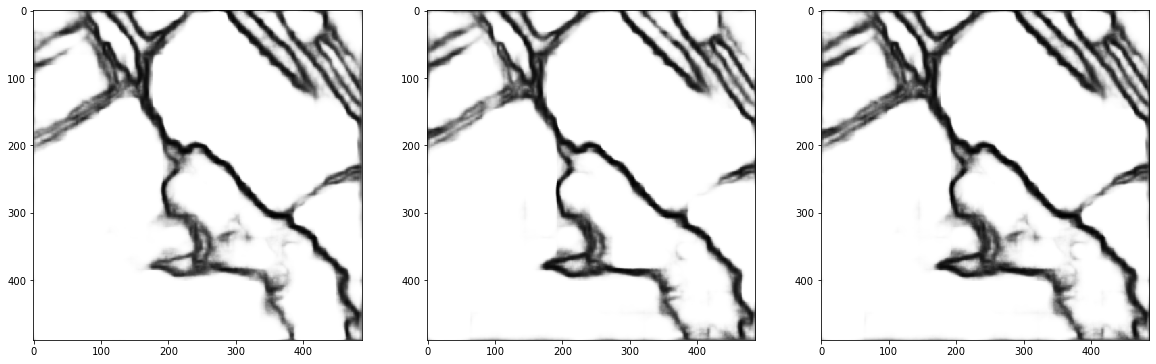

In [57]:
# combining of 2 (plain and transposed) outputs 
plt.figure(figsize=(20,20))
o1=outputs0[-2][0,:,:,0].T
o2=outputs1[-2][0,:,:,0]
o_mx=np.max(np.vstack([o1[None,],o2[None,]]),axis=0)
for num, im in enumerate([o1, o2, o_mx]):
    plt.subplot(1,3,num+1)
    plt.imshow(1-im, cmap='gray')

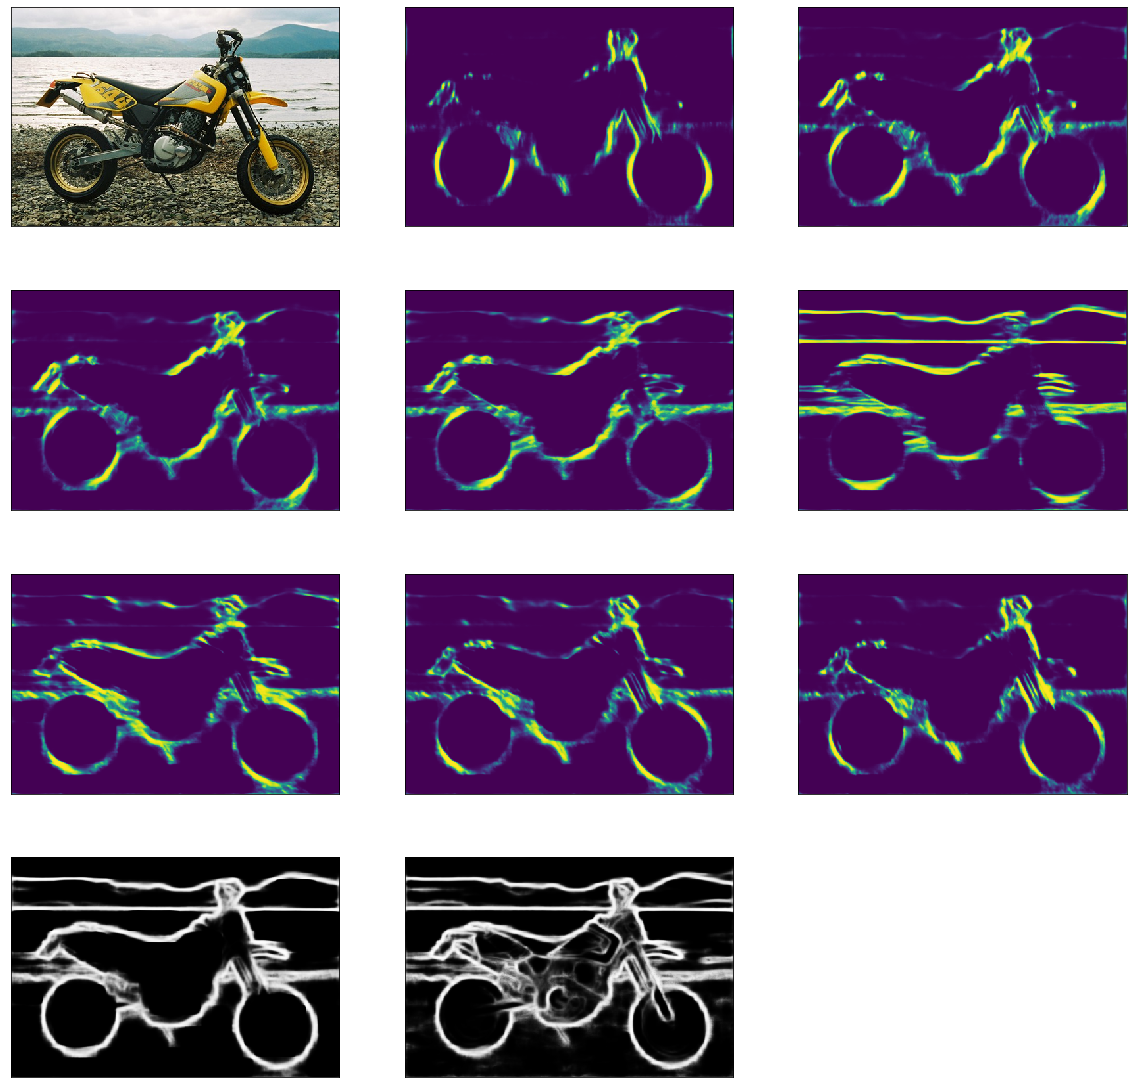

In [24]:
plt.figure(figsize=(20,20))

plt.subplot(4,3,1)
plt.imshow(img)
plt.xticks([]),plt.yticks([])


for num, im in enumerate (outputs0):
    
    plt.subplot(4,3,num+2)
    
    if num>7:
        plt.imshow(im[0,:,:,0].T, cmap='gray')
        plt.xticks([]),plt.yticks([])
    else: 
        plt.imshow(im[0,:,:,0].T)
        plt.xticks([]),plt.yticks([])
plt.show()

In [10]:
# Open intermediate layers from native model
import pickle
with open(r"d:\virt_shared\moto_out_rev.pkl", "rb") as f:
    outputs_caffe = pickle.load(f, encoding="bytes") 

In [12]:
#getting output from specified layer
def get_tf_layer(input_image, model, lr_name):
    get_layer_output = tf.keras.backend.function([model.layers[0].input],
                                  [model.get_layer(lr_name).output])
    layer_output = get_layer_output(np.array([input_image]))[0]
    return layer_output


# Caffe section

In [ ]:
import caffe
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

base=r'/home/sgr/COB/models'
PRETRAINED = '{0}/COB_PASCALContext_trainval.caffemodel'.format(base)
MODEL_FILE = '{0}/deploy.prototxt'.format(base)

img = np.asarray(Image.open(r'/home/sgr/Загрузки/COB/demos/2010_005731.png'))

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_cpu()

counter=0
for key in net.params:    
    num=net.params[key].__len__()
    out='{0:22}#{1:2}'.format(key, num)
    
    for i in range(num):
        sh=net.params[key][i].data[...].shape
#         out='{0}; {1:3} shape:{2:25}'.format(out, i, sh)
        out='{0};\t{1}: shape:{2:20}'.format(out, i+1, str(sh))
    counter+=1
    print(out)
print('Total params layer: '+str(counter))

In [6]:
mn=np.array([122.67891434, 116.66876762,104.00698793])
data=(img-mn)[:,:,[2,1,0]]
# data=np.transpose(data,axes=(1,0,2))
data=np.transpose(data,axes=(2,1,0))
# print([*data.shape])
net.blobs['data'].reshape(1, *data.shape)
net.blobs['data'].data[...]=data
res = net.forward()

# orientation section

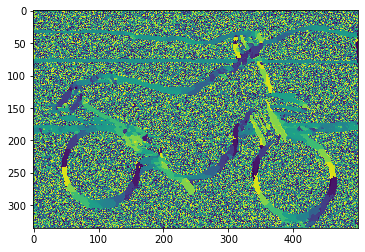

In [23]:
from segments import interpolate_angles
import numpy as np
from matplotlib import pyplot as plt

# I=np.random.rand(8,500,500)

I=np.array([out[0,:,:,0].T for out in outputs0[:-2]])
O=interpolate_angles(I)
plt.imshow(O)